#Set-Up

In [1]:
#Copy-and-paste the code below to use as "set-up" when your optimization model uses Pyomo and Coin-OR solvers.
#for reference, see https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers

%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

from pyomo.environ import *

# Reinsurance Portfolio Optimizer

This model allocates reinsurance coverage across various risk categories to minimize expected losses, stay within budget, meet regulatory capital requirements, and maximize coverage efficiency.

In [2]:
import random

# Simulated Data (Feasibility ensured)
risk_categories = ['Flood', 'Fire', 'Auto']
reinsurance_contracts = ['Contract_A', 'Contract_B', 'Contract_C']

# Expected losses per risk category
expected_loss = {'Flood': 100000, 'Fire': 80000, 'Auto': 60000}

# Recovery rate: proportion of loss covered by each contract for each risk
recovery_rate = {(risk, contract): round(random.uniform(0.4, 0.6), 2)
                 for risk in risk_categories for contract in reinsurance_contracts}

# Price per unit of coverage for each contract and risk
unit_price = {(risk, contract): round(random.uniform(1, 3), 2)
              for risk in risk_categories for contract in reinsurance_contracts}

# Maximum coverage allowed by each contract for each risk
max_coverage_limit = {(risk, contract): random.randint(20000, 50000)
                      for risk in risk_categories for contract in reinsurance_contracts}

# Fixed cost for selecting a contract
fixed_cost = {contract: random.randint(5000, 15000) for contract in reinsurance_contracts}

# Total budget for purchasing reinsurance
total_budget = 300000

# Maximum allowable retained loss after reinsurance
capital_retention_limit = 200000

# Pyomo Model
model = ConcreteModel()

model.Risks = Set(initialize=risk_categories)
model.Contracts = Set(initialize=reinsurance_contracts)

model.ExpectedLoss = Param(model.Risks, initialize=expected_loss)
model.RecoveryRate = Param(model.Risks, model.Contracts, initialize=recovery_rate)
model.UnitPrice = Param(model.Risks, model.Contracts, initialize=unit_price)
model.MaxCoverage = Param(model.Risks, model.Contracts, initialize=max_coverage_limit)
model.FixedCost = Param(model.Contracts, initialize=fixed_cost)

# Decision variables:
# Continuous variable for coverage amount purchased
model.CoverageAmount = Var(model.Risks, model.Contracts, domain=NonNegativeReals)

# Binary decision variable for contract selection
# This indicates whether a contract is chosen (1) or not (0)
model.SelectContract = Var(model.Contracts, domain=Binary)

# Objective: Minimize total expected net loss after reinsurance
def objective_rule(model):
    return sum(model.ExpectedLoss[r] - sum(model.CoverageAmount[r, c] * model.RecoveryRate[r, c]
                                            for c in model.Contracts)
               for r in model.Risks)
model.TotalNetLoss = Objective(rule=objective_rule, sense=minimize)

# Budget constraint:
# Includes both variable coverage costs and fixed costs for selected contracts
def budget_constraint_rule(model):
    return (sum(model.UnitPrice[r, c] * model.CoverageAmount[r, c]
                for r in model.Risks for c in model.Contracts)
            + sum(model.FixedCost[c] * model.SelectContract[c] for c in model.Contracts)) <= total_budget
model.BudgetConstraint = Constraint(rule=budget_constraint_rule)

# Capital retention constraint:
# Ensures total retained loss after reinsurance does not exceed the limit
def capital_constraint_rule(model):
    return sum(model.ExpectedLoss[r] - sum(model.CoverageAmount[r, c] * model.RecoveryRate[r, c]
                                           for c in model.Contracts)
               for r in model.Risks) <= capital_retention_limit
model.CapitalConstraint = Constraint(rule=capital_constraint_rule)

# Coverage linked to contract selection:
# If a contract is not selected (SelectContract[c] = 0), coverage must be zero
# If selected (SelectContract[c] = 1), coverage can go up to MaxCoverage
def coverage_selection_rule(model, r, c):
    return model.CoverageAmount[r, c] <= model.MaxCoverage[r, c] * model.SelectContract[c]
model.CoverageSelectionConstraint = Constraint(model.Risks, model.Contracts, rule=coverage_selection_rule)

# Solve
solver = SolverFactory('cbc')
results = solver.solve(model)

# Check solver status
if results.solver.termination_condition == TerminationCondition.optimal:
    # Print total expected loss before reinsurance
    total_loss_before = sum(expected_loss[risk] for risk in risk_categories)
    print(f"Total Expected Net Loss Before Reinsurance: {total_loss_before:.2f}")

    # Results: Which contracts were selected (binary variable usage)
    selected_contracts = []
    for c in model.Contracts:
        if model.SelectContract[c].value == 1:  # Binary variable indicates selection
            selected_contracts.append(c)

    print("\nSelected Contracts:")
    for c in selected_contracts:
        print(f"Contract: {c}, Fixed Cost: ${fixed_cost[c]:,.0f}")

    print("\nCoverage Details:")
    for r in model.Risks:
        for c in model.Contracts:
            coverage = model.CoverageAmount[r, c].value
            if coverage is not None and coverage > 0:
                print(f"Risk: {r}, Contract: {c}, Coverage Purchased: {coverage:.2f}")

    # Compute and print total expected net loss after reinsurance
    total_net_loss = 0
    for r in model.Risks:
        loss = model.ExpectedLoss[r]
        recovered = sum(
            model.CoverageAmount[r, c].value * model.RecoveryRate[r, c]
            if model.CoverageAmount[r, c].value is not None else 0
            for c in model.Contracts
        )
        net_loss = loss - recovered
        total_net_loss += net_loss

    print(f"\nTotal Expected Net Loss After Reinsurance: {total_net_loss:.2f}")
else:
    print("Model is infeasible or solver did not find an optimal solution.")

Total Expected Net Loss Before Reinsurance: 240000.00

Selected Contracts:
Contract: Contract_A, Fixed Cost: $10,927
Contract: Contract_B, Fixed Cost: $9,105
Contract: Contract_C, Fixed Cost: $12,558

Coverage Details:
Risk: Flood, Contract: Contract_A, Coverage Purchased: 49275.00
Risk: Fire, Contract: Contract_A, Coverage Purchased: 34010.00
Risk: Auto, Contract: Contract_A, Coverage Purchased: 21091.21
Risk: Auto, Contract: Contract_B, Coverage Purchased: 39462.00
Risk: Auto, Contract: Contract_C, Coverage Purchased: 35138.00

Total Expected Net Loss After Reinsurance: 143627.77


/tmp/ipython-input-553328684.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Stage', y='Loss', data=df, palette=['red', 'green'])


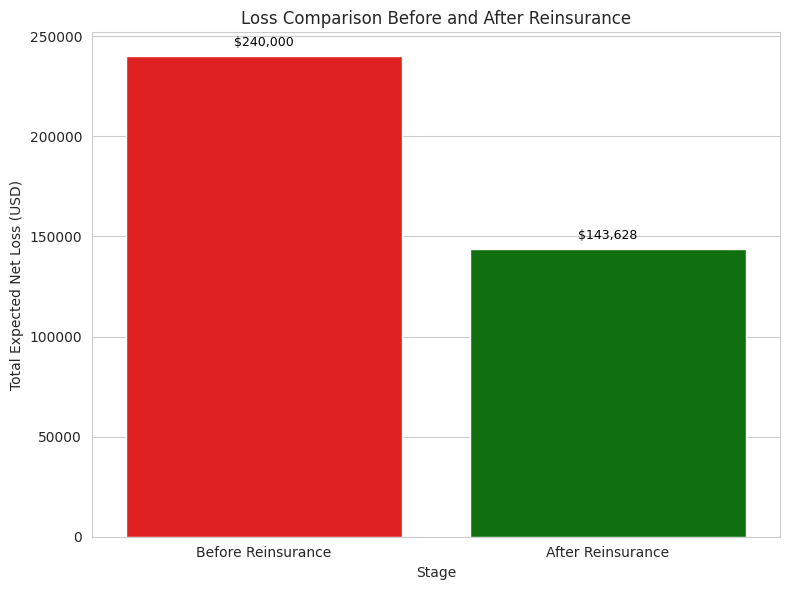

In [3]:
# importing libraries so I can create a visualization of the total expected net losses
# before and after purchasing reinsurance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for plotting
data = {
    'Stage': ['Before Reinsurance', 'After Reinsurance'],
    'Loss': [total_loss_before, total_net_loss]
}
df = pd.DataFrame(data)

# Create bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Stage', y='Loss', data=df, palette=['red', 'green'])

# Add labels and title
plt.ylabel('Total Expected Net Loss (USD)')
plt.title('Loss Comparison Before and After Reinsurance')

# Display values above bars
for index, row in df.iterrows():
    barplot.text(index, row['Loss'] + 5000, f"${row['Loss']:,.0f}", color='black', ha="center", fontsize=9)

plt.tight_layout()
plt.show()